  # Import the files & generate multi dataframes

In [1]:
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt
import os
import itertools

## Definition of functions 

In [2]:
# generate dataframes -- convert string table into the double table
import re,glob
def numericalpart(value): # will return the first number in the string 
    number=re.compile(r"(\d+)")
    parts=number.split(value)
    return int(parts[1])

def GenerateDflist(PATH):
    dflist=[]
    filelist_temp=sorted( glob.glob(PATH) , key = numericalpart )
    num=0
    for i in filelist_temp:
        time=num*0.04 # archive time is every 0.04 s
        temp_str=pd.read_csv(i,names=['Time'+str(time)])
        rows=len( temp_str['Time'+str(time)] )
        temp_str.index=range(1,rows+1)
        temp=temp_str['Time'+str(time)].str.split(r'\t',expand=True) # split into multi columns
        columns=['x','y','mat','mass','velx','vely','dispx','dispy','sxx','syy','sxy','pressure',
         'vonmises','exx','eyy','exy','pexx','peyy','pexy','equivstrain','strerg','work']
        temp.columns=columns # rename the columns
        temp=temp.apply(pd.to_numeric)
        dflist.append(temp)
        num=num+1
    return dflist

In [3]:
# the path should not contain number !!!!!!!!!!!!!!!!
path_rigid='Rigid/All/'
path_5Mpa='FiveMpa/All/' # this time step is a little bit different
path_20Mpa='TwentyMpa/All/'
path_80Mpa='EightyMpa/All/'
Figure_path='Figure/'

## Read into the data and convert 

In [4]:
filelist_rigid=GenerateDflist(path_rigid+'All_*.txt')

In [5]:
filelist_20Mpa=GenerateDflist(path_20Mpa+'All_*.txt')

In [6]:
filelist_5Mpa=GenerateDflist(path_5Mpa+'All_*.txt')

In [7]:
filelist_80Mpa=GenerateDflist(path_80Mpa+'All_*.txt')

# Plotting

## Definition of functions

In [8]:
############## Fit by polynominal ########################################### 
# INPUT: list x , list y
#        order: the order of polynominal
#        step: step of the fitted function
# OUTPUT: function 
#         xval, yval  (within the range of list x and list y)

def PolyFit(x,y,order,step):
    z1=np.polyfit(x,y,order)
    function=np.poly1d(z1)
    xval=np.arange(min(x),max(x),step)
    yval=np.polyval(z1,xval)
    return function,xval,yval
#############################################################################


In [27]:
############## Moving average ############################################### 
# INPUT: list x , list y
# OUTPUT:val_x, val_y  (within the range of list x and list y)
def moving_average(interval, window_size):
    ''' Coupute convoluted window for given size'''
    window = np.ones( int (window_size) ) /float( window_size)
    return np.convolve( interval, window,'same' )

#############################################################################

In [10]:
############## Scatter ###################################################### 
# INPUT: list x , list y
# OUTPUT:Figure
#############################################################################

## run up height against stiffness

315.0
3.8729833462074175
195.0


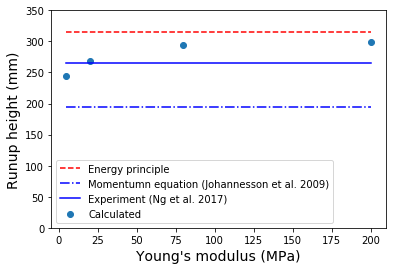

In [11]:
h=0.03 #unit m
vx= 2.1# m/s
g=9.8 # m/s^2
theta= 40.* np.pi/180
froude=vx/np.sqrt(g*h)

# energy approach
#h_f= (1+ vx**2/(g*h*np.cos(theta)))
h_f=h*10.5*1000
print (h_f)
print (froude)
# continuum approach
h_f2=6.5*0.03*1000
print (h_f2)
#simulation 
E=[5,20,80,200]
hf=[244,269,295,299]

plt.plot
plt.scatter(E,hf,label='Calculated')
plt.xlabel("Young's modulus (MPa)", fontsize=14)
plt.ylabel('Runup height (mm)', fontsize=14)

horiz_line_data = np.array([h_f for i in range(len(E))])
plt.plot(E, horiz_line_data, 'r--',label='Energy principle')

horiz_line_data = np.array([h_f2 for i in range(len(E))])
plt.plot(E, horiz_line_data, 'b-.',label='Momentumn equation (Johannesson et al. 2009)')

horiz_line_data = np.array([265 for i in range(len(E))])
plt.plot(E, horiz_line_data, 'b-',label='Experiment (Ng et al. 2017)')

#plt.title('Runup height '
plt.ylim(0,350)
name='runupheight.png'
plt.legend()
plt.savefig(Figure_path+'/RunupHeight/'+name,dpi=300)
plt.show()

## Velocity distribution along depth

In [12]:
marker=itertools.cycle( ('^','+','o','s','p','x') )
linetype=itertools.cycle( [':','-','-.'] ) 

### Different position at the same time

In [13]:
debris,base,barrier=["mat==1","mat==2","mat==3"]
Timestep=np.arange(18,40,2)
position=["x>700 & x<702","x>800 & x<802", "x>900 & x<902",
          "x>1000& x<1002","x>1100 & x<1102","x<1200 & x>1197"]
for j in range(len(Timestep)):
    for i in range(0,len(position)-3):
        filtCondition=debris +'&'+position[i]
        filtered=filelist_rigid[Timestep[j]].query( filtCondition )
        function,x,y= PolyFit(filtered.velx,filtered.y,2,5)
        #print(function)
        lb=' x= '+ str( numericalpart(position[i]) ) + ' mm'
        plt.scatter(filtered.velx,filtered.y,label= lb, marker=next(marker))
        plt.plot(x,y,label='Fitted data'+lb,linestyle=next(linetype))
    plt.legend()
    #plt.xlim(1000,)
    plt.ylim(0,)
    plt.xlabel('velocity in flow direction (mm/s)', fontsize=14)
    plt.ylabel('flow height (mm)', fontsize=14)
    plt.title('Time='+str(Timestep[j]*0.04)+' s')
    name='Position x=[700,900] Time='+str(Timestep[j]*0.04)+'s.png'
    plt.savefig(Figure_path+'/VelxDistributionRigid/SameTime/'+name,dpi=300)
    #plt.show()
    plt.close()

In [14]:
for j in range(len(Timestep)):
    for i in range(3,len(position)):
        filtCondition=debris +'&'+position[i]
        filtered=filelist_rigid[Timestep[j]].query( filtCondition )
        function,x,y= PolyFit(filtered.velx,filtered.y,2,5)
        #print(function)
        lb=' x= '+ str( numericalpart(position[i]) ) + ' mm'
        plt.scatter(filtered.velx,filtered.y,label= lb, marker=next(marker))
        plt.plot(x,y,label='Fitted data'+lb,linestyle=next(linetype))
    plt.legend()
    plt.ylim(0,)
    plt.xlabel('velocity in flow direction (mm/s)', fontsize=14)
    plt.ylabel('flow height (mm)', fontsize=14)
    plt.title('Time='+str(Timestep[j]*0.04)+' s')
    name='Position x=[1000,1200] Time='+str(Timestep[j]*0.04)+'s.png'
    plt.savefig(Figure_path+'/VelxDistributionRigid/SameTime/'+name,dpi=300)
    #plt.show()
    plt.close()

### Smae position of different time 

In [15]:
linetype=itertools.cycle( [':','-','--','-.'] ) 
marker=itertools.cycle( ('^','+','o','s') )
Timestep=np.arange(20,28,2)
position=["x>700 & x<702","x>800 & x<802", "x>900 & x<902",
          "x>1000& x<1002","x>1100 & x<1102","x<1200 & x>1197"]
for i in range(0,len(position)-3):
    for j in range(len(Timestep)):
        filtCondition=debris +'&'+position[i]
        filtered=filelist_rigid[Timestep[j]].query( filtCondition )
        function,x,y= PolyFit(filtered.velx,filtered.y,2,5)
        #print(function)
        lb=' t= '+ str( Timestep[j]*0.04 ) + ' s'
        plt.scatter(filtered.velx,filtered.y,label= lb, marker=next(marker))
        plt.plot(x,y,label='Fitted data'+lb,linestyle=next(linetype))
    plt.legend()
    #plt.xlim(1000,)
    plt.ylim(0,)
    plt.xlabel('velocity in flow direction (mm/s)', fontsize=14)
    plt.ylabel('flow height (mm)', fontsize=14)
    plt.title('Position x= '+ str( numericalpart(position[i]) ) + ' mm')
    name='[700,900] '+ position[i] + 'Time='+str(Timestep[j]*0.04)+'s.png'
    plt.savefig(Figure_path+'/VelxDistributionRigid/SamePosition/'+name,dpi=300)
    #plt.show()
    plt.close()

In [16]:
for i in range(3,len(position)):
    for j in range(len(Timestep)):
        filtCondition=debris +'&'+position[i]
        filtered=filelist_rigid[Timestep[j]].query( filtCondition )
        function,x,y= PolyFit(filtered.velx,filtered.y,2,5)
        #print(function)
        lb=' t= '+ str( Timestep[j]*0.04 ) + ' s'
        plt.scatter(filtered.velx,filtered.y,label= lb, marker=next(marker))
        plt.plot(x,y,label='Fitted data'+lb,linestyle=next(linetype))
    plt.legend()
    #plt.xlim(1000,)
    plt.ylim(0,)
    plt.xlabel('velocity in flow direction (mm/s)', fontsize=14)
    plt.ylabel('flow height (mm)', fontsize=14)
    plt.title('Position x= '+ str( numericalpart(position[i]) ) + ' mm')
    name='Same Position x=[1000,1200]'+ position[i]+'Time='+str(Timestep[j]*0.04)+'s.png'
    plt.savefig(Figure_path+'/VelxDistributionRigid/SamePosition/'+name,dpi=300)
    #plt.show()
    plt.close()

## Impact pressure before the barrier

In [17]:
def AveragePressure(list1):
    if len(list1)==0:
        return 0
    else:
        return sum(list1)/len(list1)
def ForceSeries(dflist,filtCondition):
    F=[]
    Time=[]
    num=0
    for i in dflist:
        filtered= i.query( filtCondition )
        F.append( AveragePressure(filtered.vonmises.tolist() ) )
        Time.append(num*0.04)
        num+=1
    return F,Time

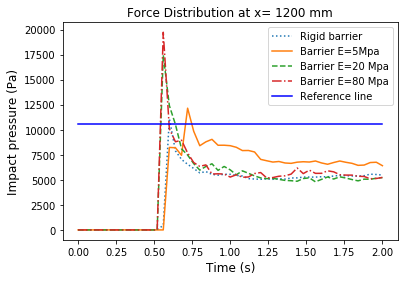

In [18]:
linetype=itertools.cycle( [':','-','--','-.'] ) 
debris,base,barrier,position=["mat==1","mat==2","mat==3","x>1197 & x<1200"]
filtCondition_force =debris +'&'+position
#filtered=filelist_rigid[25].query( filtCondition_force )

F_rigid,t=ForceSeries(filelist_rigid,filtCondition_force)
F_5Mpa,t2=ForceSeries(filelist_5Mpa,filtCondition_force)
F_20Mpa,t=ForceSeries(filelist_20Mpa,filtCondition_force)
F_80Mpa,t=ForceSeries(filelist_80Mpa,filtCondition_force)
plt.plot(t,F_rigid,label='Rigid barrier',linestyle=next(linetype))
t2[:]=[x-1 for x in t2]
plt.plot(t2[25:],F_5Mpa[25:],label='Barrier E=5Mpa',linestyle=next(linetype))
plt.plot(t,F_20Mpa,label='Barrier E=20 Mpa',linestyle=next(linetype))
plt.plot(t,F_80Mpa,label='Barrier E=80 Mpa',linestyle=next(linetype))

p_analytical=2650*(2**2)
horiz_line_data = np.array([p_analytical for i in range(len(t))])
plt.plot(t, horiz_line_data, 'b-',label='Reference line')
plt.legend(loc='upper right')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Impact pressure (Pa)', fontsize=12)
plt.title('Force Distribution at x= 1200 mm')
plt.savefig(Figure_path+'/Force x= 1200.png',dpi=300)
plt.show()
plt.close()

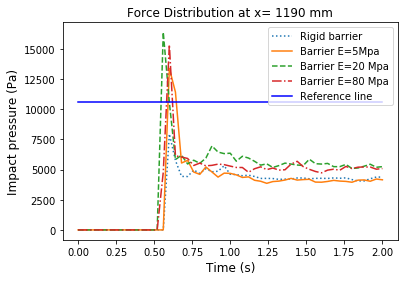

In [19]:
linetype=itertools.cycle( [':','-','--','-.'] ) 
debris,base,barrier,position=["mat==1","mat==2","mat==3","x>1190 & x<1192"]
filtCondition_force =debris +'&'+position
#filtered=filelist_rigid[25].query( filtCondition_force )

F_rigid,t=ForceSeries(filelist_rigid,filtCondition_force)
F_5Mpa,t2=ForceSeries(filelist_5Mpa,filtCondition_force)
F_20Mpa,t=ForceSeries(filelist_20Mpa,filtCondition_force)
F_80Mpa,t=ForceSeries(filelist_80Mpa,filtCondition_force)
plt.plot(t,F_rigid,label='Rigid barrier',linestyle=next(linetype))
t2[:]=[x-1 for x in t2]
plt.plot(t2[25:],F_5Mpa[25:],label='Barrier E=5Mpa',linestyle=next(linetype))
plt.plot(t,F_20Mpa,label='Barrier E=20 Mpa',linestyle=next(linetype))
plt.plot(t,F_80Mpa,label='Barrier E=80 Mpa',linestyle=next(linetype))

p_analytical=2650*(2**2)
horiz_line_data = np.array([p_analytical for i in range(len(t))])
plt.plot(t, horiz_line_data, 'b-',label='Reference line')
plt.legend(loc='upper right')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Impact pressure (Pa)', fontsize=12)
plt.title('Force Distribution at x= 1190 mm')
plt.savefig(Figure_path+'/Force x=1190.png',dpi=300)
plt.show()
plt.close()

[7.91939e+03 3.81704e+03 1.17369e+04 2.00084e+04 7.00361e+03 2.74850e+03
 7.71803e+02 1.88423e+04 8.24217e+02 1.32162e+04 3.55922e+01 1.62598e+04
 9.84703e+03 1.60295e+03 2.73609e+02 2.01633e+01 3.30902e+02 8.24370e+01
 2.94685e+04 5.19058e+03 4.22891e+03 7.36821e+02 7.42589e+02 1.00959e+04
 2.58311e+04 2.80531e+02 2.75756e+03 2.18480e+02 1.03737e+02 3.35865e+04
 9.82046e+03 1.91400e+03 1.18802e+03 2.01185e+04 7.88568e+02 2.04087e+04
 1.43734e+03 1.36032e+04 7.97111e+03 6.58429e+03 1.35851e+03 3.40841e+03
 1.30640e+02 3.14039e+02 4.40000e+04 9.98372e+03 6.10058e+02 1.89925e+02
 4.92997e+03 1.32408e+04 9.59377e+02 2.90231e+03 1.96261e+04 5.51848e+03
 2.90135e+04 1.51728e+03 3.98533e+02 1.45702e+03 3.59222e+02 2.29285e+03
 2.50248e+03 1.15778e+03 2.43632e+02 1.83459e+02 1.50340e+03 1.27493e+03
 7.96103e+03 6.12307e+03 7.37957e+03 3.00306e+03 2.93014e+03 1.48999e+04
 2.44645e+01 1.81174e+03 4.28985e+01 6.80763e+03 2.54348e+03 1.55908e+04
 5.29596e+02 8.26096e+03 6.02582e+02 7.81821e+03 3.

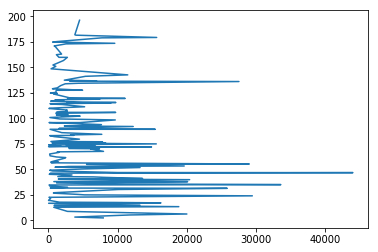

In [47]:
debris,base,barrier,position=["mat==1","mat==2","mat==3","x>1198& x<1200"]
filtCondition_force =debris +'&'+position
F_sxx_raw= filelist_rigid[25].query(filtCondition_force)
F_sxx=F_sxx_raw.sort_values(['y'])
F_vonmises_avg=moving_average(F_sxx.vonmises,1)
#plt.scatter(F_sxx.vonmises,F_sxx.y)
plt.plot(F_vonmises_avg,F_sxx.y)
print ( F_vonmises_avg, len(F_sxx))
plt.show()
plt.close()

In [21]:
filelist_20Mpa[0].head()
print ( len(filelist_20Mpa) )

51
